<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/AE/AE_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder


## Import and Config

In [1]:
!pip install -q --upgrade albumentations==0.5.1

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 28, 28

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

## Define Model

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, dim=32, in_channel=1):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.module_encoder = nn.Sequential(
            Flatten(),
            nn.Linear(IN_HEIGHT * IN_WIDTH * in_channel, dim * 16),
            nn.ReLU(),
            nn.Linear(dim * 16, dim * 8),
            nn.ReLU(),
            nn.Linear(dim * 8, dim),
            nn.ReLU(),
        )
        
        # Decoder
        self.module_decoder = nn.Sequential(
            nn.Linear(dim, dim * 8),
            nn.ReLU(),
            nn.Linear(dim * 8, dim * 16),
            nn.ReLU(),
            nn.Linear(dim * 16, IN_WIDTH * IN_HEIGHT * in_channel),
            nn.Tanh(),
            Reshape(in_channel, IN_HEIGHT, IN_WIDTH)
        )
        
    def forward(self, x):
        x = self.module_encoder(x)
        return self.module_decoder(x)
    
    def forward_encoder(self, x):
        return self.module_encoder(x)

# Dataset

In [5]:
train_ds = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data.numpy()[..., None].astype(np.float32)
train_ys = np.array(train_ds.targets)

class MnistDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [6]:
transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [7]:
def show_sample(Xs, ys, show_num=8):
    Xs = Xs.detach().cpu().numpy()[:, 0]
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = ys.detach().cpu().numpy()[:, 0]
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
        
    plt.figure(figsize=(12, 2))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(2, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        y = ys[i]
        plt.subplot(2, show_num, i + 1 + show_num)
        plt.imshow(y, cmap="gray")
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.show()

In [10]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    EPOCH = 10
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = MnistDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = MnistDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        model = AutoEncoder()
        model = model.to(device)
        
        criterion = nn.MSELoss()
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
  
        #---
        # epoch
        #---
        for epoch in range(EPOCH):
            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, xs)
                loss = loss# / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += 0#(predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, xs)
                        
                    val_loss += loss.item()# / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += 0#(predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} [val]loss:{val_loss:.4f} [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

            show_sample(xs, outputs)

        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()

        
    return train_models, train_model_paths


StratifiedKFold fold:1/2
train_N=30000, val_N=30000
fold:1 epoch:1/10 [tra]loss:18.8934 [val]loss:15.8302 [time]total:4.80sec tra:2.66sec val:2.13sec


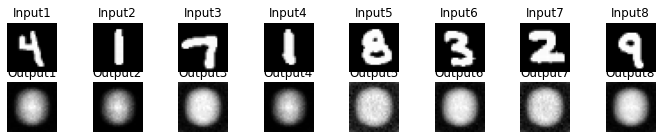

fold:1 epoch:2/10 [tra]loss:14.4540 [val]loss:12.7416 [time]total:5.33sec tra:2.69sec val:2.64sec


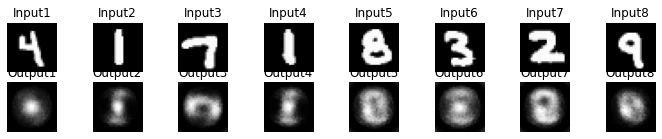

fold:1 epoch:3/10 [tra]loss:11.0870 [val]loss:9.7027 [time]total:5.09sec tra:2.76sec val:2.32sec


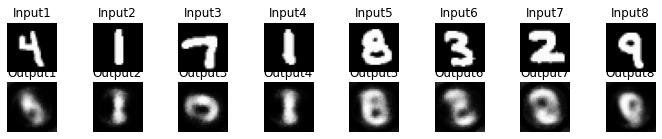

fold:1 epoch:4/10 [tra]loss:9.1160 [val]loss:8.0306 [time]total:5.12sec tra:2.81sec val:2.31sec


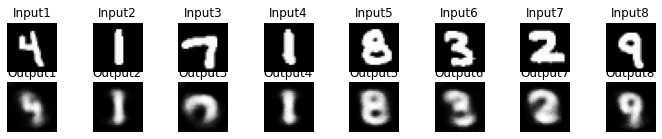

fold:1 epoch:5/10 [tra]loss:8.0659 [val]loss:7.2791 [time]total:4.89sec tra:2.61sec val:2.28sec


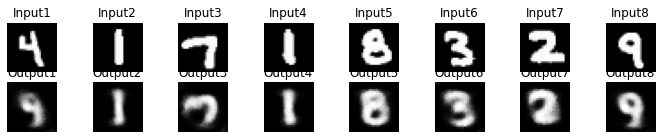

fold:1 epoch:6/10 [tra]loss:7.4205 [val]loss:6.6326 [time]total:5.32sec tra:2.68sec val:2.64sec


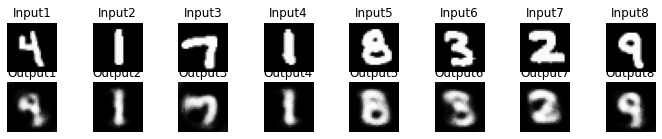

fold:1 epoch:7/10 [tra]loss:6.7272 [val]loss:6.1076 [time]total:4.94sec tra:2.64sec val:2.30sec


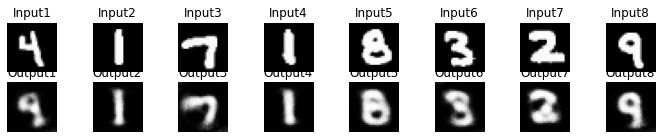

fold:1 epoch:8/10 [tra]loss:6.2574 [val]loss:5.6414 [time]total:5.24sec tra:2.56sec val:2.68sec


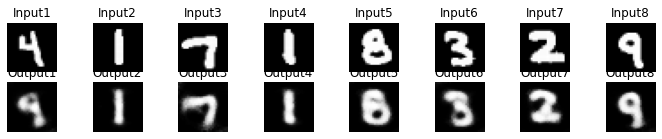

fold:1 epoch:9/10 [tra]loss:5.8601 [val]loss:5.3835 [time]total:5.11sec tra:2.69sec val:2.42sec


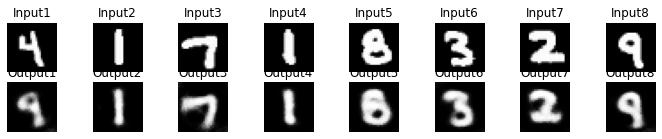

fold:1 epoch:10/10 [tra]loss:5.5128 [val]loss:5.1144 [time]total:4.99sec tra:2.65sec val:2.35sec


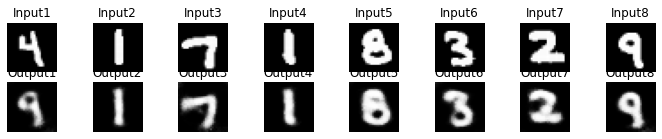

model saved to >> model_epoch10_StratifiedKFold_1_2.pth



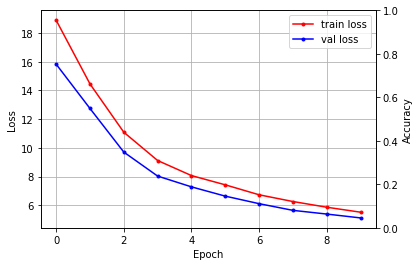

StratifiedKFold fold:2/2
train_N=30000, val_N=30000
fold:2 epoch:1/10 [tra]loss:19.2963 [val]loss:15.9039 [time]total:4.64sec tra:2.65sec val:1.99sec


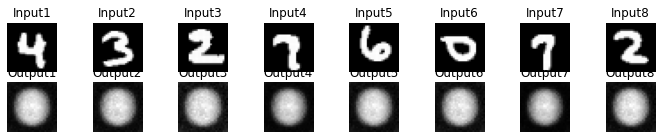

fold:2 epoch:2/10 [tra]loss:14.1079 [val]loss:12.2284 [time]total:4.75sec tra:2.75sec val:2.00sec


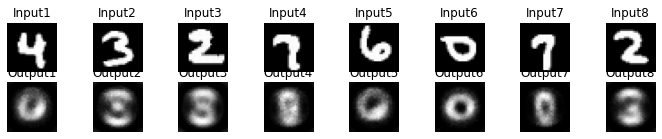

fold:2 epoch:3/10 [tra]loss:10.8859 [val]loss:9.6812 [time]total:5.07sec tra:2.68sec val:2.39sec


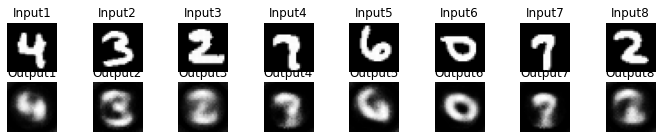

fold:2 epoch:4/10 [tra]loss:9.1228 [val]loss:8.2173 [time]total:5.19sec tra:2.68sec val:2.51sec


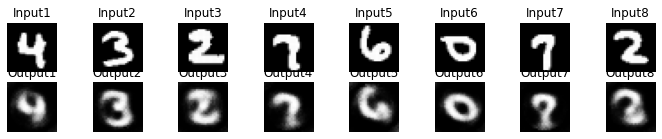

fold:2 epoch:5/10 [tra]loss:8.1352 [val]loss:7.3329 [time]total:4.99sec tra:2.62sec val:2.37sec


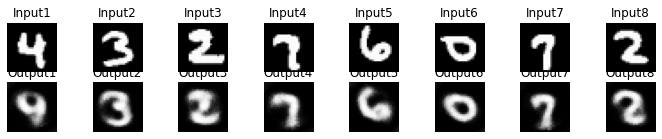

fold:2 epoch:6/10 [tra]loss:7.4088 [val]loss:6.6248 [time]total:5.22sec tra:2.78sec val:2.43sec


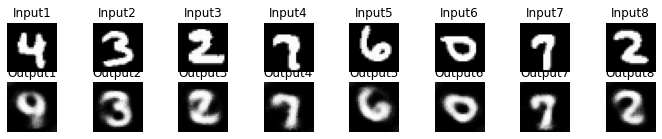

fold:2 epoch:7/10 [tra]loss:6.7433 [val]loss:6.1953 [time]total:4.88sec tra:2.56sec val:2.32sec


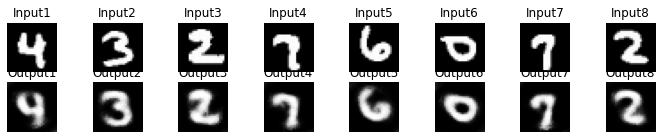

fold:2 epoch:8/10 [tra]loss:6.2774 [val]loss:5.7273 [time]total:5.08sec tra:2.79sec val:2.29sec


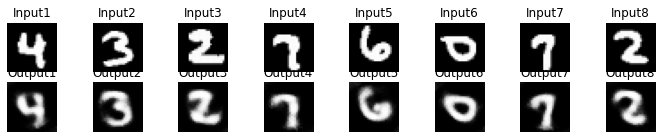

fold:2 epoch:9/10 [tra]loss:5.8601 [val]loss:5.3093 [time]total:5.37sec tra:2.67sec val:2.70sec


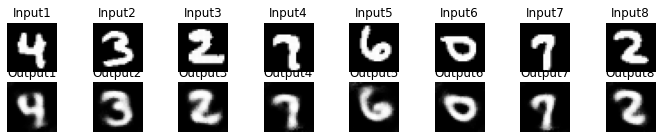

fold:2 epoch:10/10 [tra]loss:5.5517 [val]loss:5.0766 [time]total:5.18sec tra:2.79sec val:2.39sec


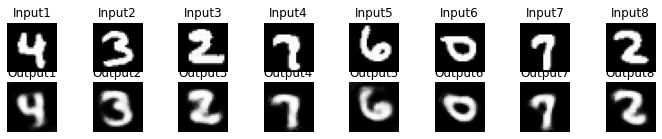

model saved to >> model_epoch10_StratifiedKFold_2_2.pth



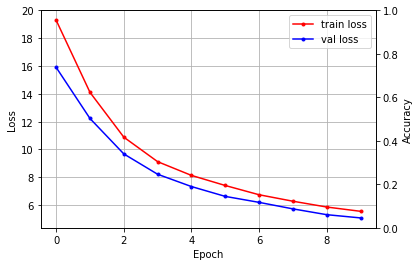

In [11]:
train_models, train_model_paths = train()

# Test

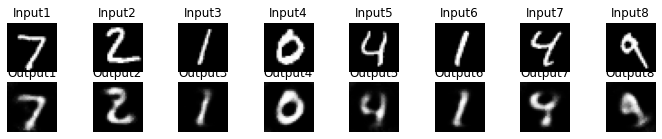

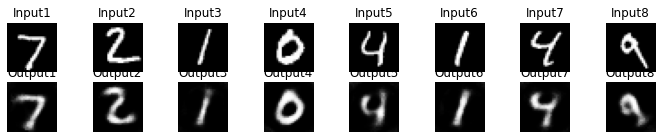

In [16]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data.numpy().astype(np.float32)[..., None]
    test_ys = np.array(test_ds.targets)

    dataset_test = MnistDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = model(Xs)

                show_sample(Xs, model_preds)

            break

test(train_models)